# World Wide Products Inc.

a project for EECS 731 by Benjamin Wyss

Examining historical product demand data to build time series forecasting models which predict the future demand for products

###### python imports

In [74]:
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
plt.close('all')
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

### Reading Data Sets From CSV

Historical Product Demand

Taken from: https://www.kaggle.com/felixzhao/productdemandforecasting on 10/6/20

###### Historical Product Demand Data Set

In [75]:
df = pd.read_csv('../data/raw/Historical Product Demand.csv')

In [76]:
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


## The Big Ideas

Feature engineering and transformation can add value to this data set for building time series forecasting models in the following ways:

(1): By splitting the Date column into multiple columns for day, month, and year, and then binning these values into weeks, time interval granularity can be adjusted to yield the best results.

(2): By one-hot encoding the Warehouse column, time series forecasting models can reason about the demand for a product at different warehouses, which should improve the model's results if different warehouses have different magnitudes of demand.

(3): By selecting only the most promising and demand-correlated attributes as input features, time series forecasting models can achieve better results which are not tainted by detrimental input features.

(4): By separating the data set into multiple data sets which correspond to a single product, separate time series forecasting models can be built for each product so that each model achieves the best possible results.

## Exploratory Data Analysis

### Cleaning the Data Set

The Product_Category column is removed since I will be building time series forecasting models on a per-product basis. Since an individual product's category should not change throughout time, this column does not add any value to a time series forecasting model.

In [77]:
df = df[['Product_Code', 'Warehouse', 'Date', 'Order_Demand']]

In [78]:
df

,Product_Code,Warehouse,Date,Order_Demand
0,Product_0993,Whse_J,2012/7/27,100
1,Product_0979,Whse_J,2012/1/19,500
2,Product_0979,Whse_J,2012/2/3,500
3,Product_0979,Whse_J,2012/2/9,500
4,Product_0979,Whse_J,2012/3/2,500
...,...,...,...,...
1048570,Product_1791,Whse_J,2016/4/27,1000
1048571,Product_1974,Whse_J,2016/4/27,1
1048572,Product_1787,Whse_J,2016/4/28,2500
1048573,Product_0901,Whse_J,2016/10/7,50


The Product_Code and Warehouse columns' prefixes are removed so that the data set is easier to read.

In [79]:
df['Product_Code'] = df['Product_Code'].str[-4:]
df['Warehouse'] = df['Warehouse'].str[-1:]

In [80]:
df

,Product_Code,Warehouse,Date,Order_Demand
0,0993,J,2012/7/27,100
1,0979,J,2012/1/19,500
2,0979,J,2012/2/3,500
3,0979,J,2012/2/9,500
4,0979,J,2012/3/2,500
...,...,...,...,...
1048570,1791,J,2016/4/27,1000
1048571,1974,J,2016/4/27,1
1048572,1787,J,2016/4/28,2500
1048573,0901,J,2016/10/7,50


The Order_Demand column is converted to a numeric type so that time series forecasting models can reason about the data.

When converting the Order_Demand column to a numeric type, some rows have a negative demand (indicated with parentheses). A product should not be able to have a negative demand, so these rows are dropped.

In [81]:
df = df[df.Order_Demand.str[0] != '(']
df['Order_Demand'] = df['Order_Demand'].astype(float)

In [82]:
df

,Product_Code,Warehouse,Date,Order_Demand
0,0993,J,2012/7/27,100.0
1,0979,J,2012/1/19,500.0
2,0979,J,2012/2/3,500.0
3,0979,J,2012/2/9,500.0
4,0979,J,2012/3/2,500.0
...,...,...,...,...
1048570,1791,J,2016/4/27,1000.0
1048571,1974,J,2016/4/27,1.0
1048572,1787,J,2016/4/28,2500.0
1048573,0901,J,2016/10/7,50.0


The data set is sorted by the Date column so that time series forecasting models can be trained sequentially by date.

In [83]:
df = df.sort_values(by=['Date'])

In [84]:
df

,Product_Code,Warehouse,Date,Order_Demand
44799,0965,A,2011/1/8,2.0
75193,0642,C,2011/10/31,3.0
44795,0965,A,2011/11/18,1.0
44450,0980,A,2011/11/18,4000.0
44796,0965,A,2011/11/21,3.0
...,...,...,...,...
901973,1423,A,NaN,500.0
901974,1424,A,NaN,1400.0
901975,1419,A,NaN,600.0
981716,0130,A,NaN,20.0


Some rows have no listed Date attribute. These rows are dropped from the data set because date information is necessary to build time series forecasting models.

In [85]:
df = df.dropna()

In [86]:
df

,Product_Code,Warehouse,Date,Order_Demand
44799,0965,A,2011/1/8,2.0
75193,0642,C,2011/10/31,3.0
44795,0965,A,2011/11/18,1.0
44450,0980,A,2011/11/18,4000.0
44796,0965,A,2011/11/21,3.0
...,...,...,...,...
920140,0025,J,2017/1/6,500.0
921384,1316,J,2017/1/6,10000.0
863020,1904,C,2017/1/9,4000.0
908844,0471,C,2017/1/9,30.0


### Transforming the data set

##### Column Splitting the Date Column

The Date column is split into 3 columns--Year, Month, and Day, so that a numeric representation of this data is obtained. Once this column is split, the original Date column is removed from the data set because it is a textual representation of the data which a time series forecasting model cannot reason about.

In [87]:
yearMonthDay = df['Date'].str.split('/', n=2, expand=True)
df['Year'] = pd.to_numeric(yearMonthDay[0])
df['Month'] = pd.to_numeric(yearMonthDay[1])
df['Day'] = pd.to_numeric(yearMonthDay[2])
date = df.pop('Date')

In [88]:
df

,Product_Code,Warehouse,Order_Demand,Year,Month,Day
44799,0965,A,2.0,2011,1,8
75193,0642,C,3.0,2011,10,31
44795,0965,A,1.0,2011,11,18
44450,0980,A,4000.0,2011,11,18
44796,0965,A,3.0,2011,11,21
...,...,...,...,...,...,...
920140,0025,J,500.0,2017,1,6
921384,1316,J,10000.0,2017,1,6
863020,1904,C,4000.0,2017,1,9
908844,0471,C,30.0,2017,1,9


### Exporting Transformed Data Set to CSV

In [89]:
df.to_csv('../data/processed/product_demand_transformed.csv')

### Visualizing the Data

First, some basic statistics of the data set and correlation coefficients are calculated

In [90]:
df.describe()

,Order_Demand,Year,Month,Day
count,1.031437e+06,1.031437e+06,1.031437e+06,1.031437e+06
mean,4.962992e+03,2.013962e+03,6.508216e+00,1.557185e+01
std,2.911306e+04,1.388986e+00,3.446524e+00,8.801473e+00
min,0.000000e+00,2.011000e+03,1.000000e+00,1.000000e+00
25%,2.000000e+01,2.013000e+03,3.000000e+00,8.000000e+00
50%,3.000000e+02,2.014000e+03,7.000000e+00,1.600000e+01
75%,2.000000e+03,2.015000e+03,1.000000e+01,2.300000e+01
max,4.000000e+06,2.017000e+03,1.200000e+01,3.100000e+01


In [91]:
df.corr()

,Order_Demand,Year,Month,Day
Order_Demand,1.000000,0.008237,-0.000694,-0.001938
Year,0.008237,1.000000,-0.007795,-0.006973
Month,-0.000694,-0.007795,1.000000,-0.034732
Day,-0.001938,-0.006973,-0.034732,1.000000


###### Generating Interesting Plots

KeyError: 'spi1'

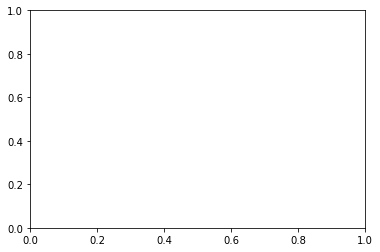

In [92]:
df.plot.scatter(x='spi1', y='score1', title='Team 1 SPI Score vs. Team 1 Match Score')

###### Intuitions Gained From Visualizations

### Model Construction

A variety of machine learning regression models using a variety of input features will be tested and compared based on their coefficient of determination (r2_score).

First, the pandas dataframe is converted to numpy arrays of input features (X arrays) and output regression targets (Y arrays). I will test ___

### Testing Different Models With 10-Fold Time Series Validation

I will test ___

10-fold cross validation r2_score is selected as the scoring metric because 10-fold cross validation will reduce overfitting, and the target model should be the model with predictions most closely matching the test data.

#### Generating a k=10 Time Series kFold Object to Pass to Cross-Validation Functions

In [ ]:
kFold = StratifiedKFold(n_splits=10, shuffle=True)

## Results

Put Results Here :)